## Week 4: Sequence alignment and evolution
### Radhika Jangi 10/11/2020

In [2]:
# Import statements
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from scipy import stats
from statsmodels.stats import weightstats as stests

In [4]:
# Mike's fasta reading class for dictionary creation
from fasta_iterator_class import FASTAReader

### 1. BLAST search
See uploaded screenshot of changed blastn parameters

### 2. Multiple sequence alignment

Commands for translating nucleotide sequences to amino acid and for multiple sequence alignment
>transeq seqdump.txt outseq.txt<br/>
mafft outseq.txt > aligned_prot.fa

### 3. Converting back to nucleotides
Here, we created a dictionary with the key = sequence id, and the value = a list containing the aligned nucleotide  and amino acid sequences

In [5]:
def dict_maker(aa_file, nuc_file):
    seq_dict = {}
    aa_seq = FASTAReader(open(aa_file))  # FASTAreader is able to create tuples with id and sequence
    nuc_seq = FASTAReader(open(nuc_file)) # which is key to dictionary creation

    for seq_id,nuc_sequence in nuc_seq:
        seq_id_split = seq_id.split()
        add_underscore = str(seq_id_split[0]) + '_1' # add _ to first element so it matches seq id
        seq_id_split[0] = add_underscore # Replaces first element to new string with underscore
        new_seq_id = ' '.join(seq_id_split) # Rejoins list into string
        seq_dict.setdefault(new_seq_id,[nuc_sequence]) # New key,val with just nuc sequence
    
    for seq_id,aa_sequence in aa_seq:
        seq_dict[seq_id].append(aa_sequence) # Append aa seq to val list
    
    return seq_dict

In [6]:
seq_dict = dict_maker('aligned_prot.fa','seqdump.txt') # Create dictionary with our files

In [7]:
# Here we add gaps in our nucleotide sequences based on the gapping in the amino acid sequences
for key, value in seq_dict.items():
    # Key = seq id, value = [DNA,Amino Acids]
    count = 0
    res = list(value[0]) # value[0] = nuc seq
    for i in range(len(value[1])): # value[1] = amino acid seq
        if value[1][i] == '-':
            res.insert((count), '---') # 3 nuc gap for single aa gap
            res2 = ''.join(res)
            res = list(res2)
        count = count+3
    value[0] = ''.join(res) # Replaces ungapped nuc acid seq with gapped one     

### 4. Looking for selection
Here we start to calculate the dN and dS values for each codon in our original sequence

In [7]:
codontable = {
'ATA':'I', 'ATC':'I', 'ATT':'I', 'ATG':'M',
'ACA':'T', 'ACC':'T', 'ACG':'T', 'ACT':'T',
'AAC':'N', 'AAT':'N', 'AAA':'K', 'AAG':'K',
'AGC':'S', 'AGT':'S', 'AGA':'R', 'AGG':'R',
'CTA':'L', 'CTC':'L', 'CTG':'L', 'CTT':'L',
'CCA':'P', 'CCC':'P', 'CCG':'P', 'CCT':'P',
'CAC':'H', 'CAT':'H', 'CAA':'Q', 'CAG':'Q',
'CGA':'R', 'CGC':'R', 'CGG':'R', 'CGT':'R',
'GTA':'V', 'GTC':'V', 'GTG':'V', 'GTT':'V',
'GCA':'A', 'GCC':'A', 'GCG':'A', 'GCT':'A',
'GAC':'D', 'GAT':'D', 'GAA':'E', 'GAG':'E',
'GGA':'G', 'GGC':'G', 'GGG':'G', 'GGT':'G',
'TCA':'S', 'TCC':'S', 'TCG':'S', 'TCT':'S',
'TTC':'F', 'TTT':'F', 'TTA':'L', 'TTG':'L',
'TAC':'Y', 'TAT':'Y', 'TAA':'_', 'TAG':'_',
'TGC':'C', 'TGT':'C', 'TGA':'_', 'TGG':'W'
}

In [74]:
# Pull our query sequences out of our dictionary b/c they've already been gapped and backtranslated
query = seq_dict['NC_001563.2_1 West Nile virus lineage 2, complete genome']
nuc_ref = query[0]
aa_ref = query[1]

In [9]:
'''Calculate dS/dN for each position in 
seqs relative to position in query'''

ds_vals = []
dn_vals = []

for i in range(0,len(nuc_ref),3): 
    if nuc_ref[i] == '-': # nuc_ref[i] = a 3 nuc codon
        continue
    else:
        dS = 0
        dN = 0
        for names, seqs in seq_dict.items():

            if nuc_ref[i:i+3] == seqs[0][i:i+3]: # If no difference in codon, we skip
                continue
                
            elif seqs[0][i:i+3] == '---': # Skip gaps
                continue
                
            else: 

                if seqs[0][i:i+3] not in codontable: # We can't calculate dS or dN for a codon that doesn't exist
                    continue
                else:
                    if codontable[nuc_ref[i:i+3]] == codontable[seqs[0][i:i+3]]: # Synonymous mutation
                        dS+=1
                    else:
                        dN+=1 # Non-synonymous mutation
        ds_vals.append(dS)
        dn_vals.append(dN)

Here are the hypotheses for our z-test
$$ H0: dN-dS = 0 $$
$$ H1: dN-dS != 0 $$
$$ alpha = 0.05 $$

In [52]:
df = pd.DataFrame(list(zip(dn_vals, ds_vals)), columns =['DN', 'DS']) #zip together two lists (dn and ds) so that 
# list(zip(dn_vals, ds_vals)
df2 = df.loc[df["DS"] != 0]
df3 = df2.loc[df["DN"] != 0]
df3["dn_df"] = df3['DN']/df['DS'] # Calculate ratio for graphing
df3['D'] = df3['DN'] - df3['DS'] # Calculate dN-dS for z test
df3

,DN,DS,dn_df,D
0,160,36,4.444444,124
1,50,13,3.846154,37
2,200,7,28.571429,193
3,212,2,106.000000,210
5,212,10,21.200000,202
...,...,...,...,...
3649,709,29,24.448276,680
3650,759,7,108.428571,752
3651,747,5,149.400000,742
3652,732,16,45.750000,716


In [85]:
pvalues = []
z = stats.zscore(df3['D']) # Calculates z scores for each point

for i in range(len(df3["D"])):
    pvalues.append(stats.norm.sf(abs(z[i]))) # Calculates p-values for each point based on z scores
df3["pvalues"] = pvalues # Add to dataframe for plotting

In [90]:
xaxis = range(len(df3)) # Renumber axis so it's sequential

NameError: name 'df3' is not defined

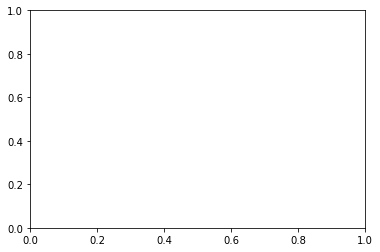

In [3]:
# Plot ratios along with colored significant points
fig, ax = plt.subplots()
colors = ['indigo' if pval < 0.025 else 'None' for pval in df3['pvalues']]
ax.scatter(x = xaxis, y = df3['dn_df'], color = 'thistle')
ax.scatter(x = xaxis, y = df3['dn_df'], color = colors, marker= '*')
ax.set_yscale('log', base=2)
plt.title('dN/dS Selection by Codon')
plt.xlabel('Codon')
plt.ylabel('Log2 dN/dS')
plt.show()

The darker purple stars are the significant points (p-value < 0.05, or 0.025 because this is a two tailed z test)